Response Rate by Campaign Channel:
  campaign_channel  total_sent  total_responded  response_rate
0               TV         207               56          27.05
1              SMS         200               53          26.50
2            Email         214               56          26.17
3     Social Media         189               48          25.40
4            Radio         190               41          21.58

Total Revenue by Region:
  region  total_revenue
0  South       19292.88
1   West       16965.01
2  North       15570.11
3   East       14683.43

Monthly Campaign Response Trend:
      month  sent  responded
0   2024-04    27          8
1   2024-05    84         21
2   2024-06    87         16
3   2024-07    64         15
4   2024-08    97         32
5   2024-09    89         25
6   2024-10    84         24
7   2024-11    86         14
8   2024-12    79         19
9   2025-01   104         29
10  2025-02    72         24
11  2025-03    80         14
12  2025-04    47         13



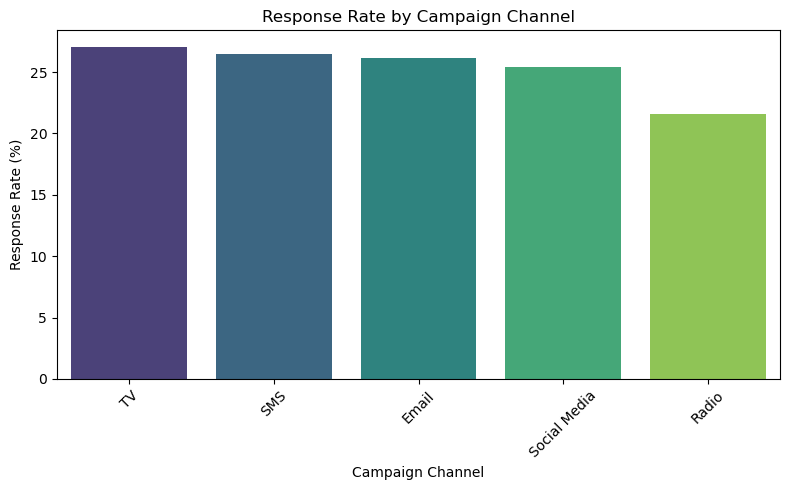

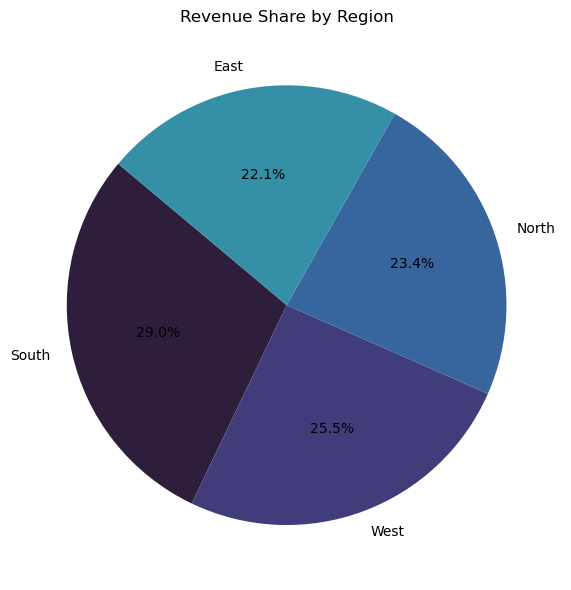

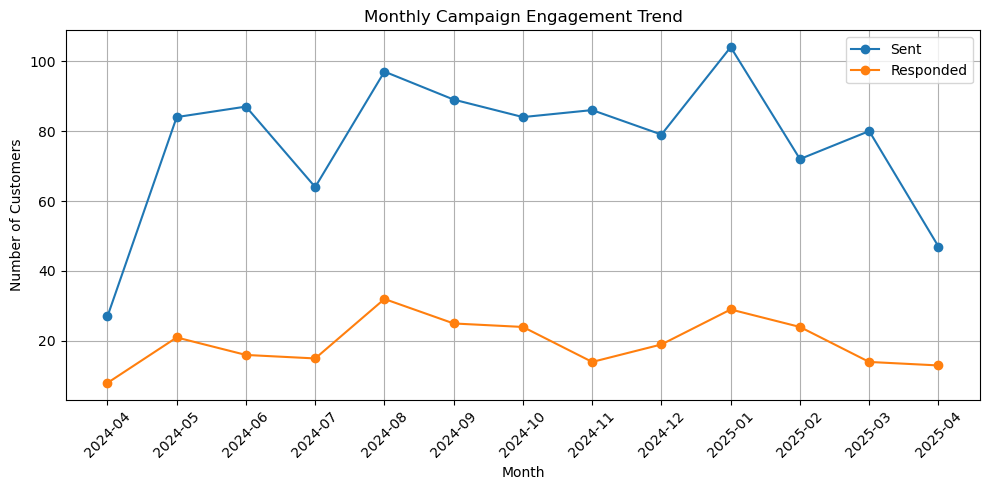

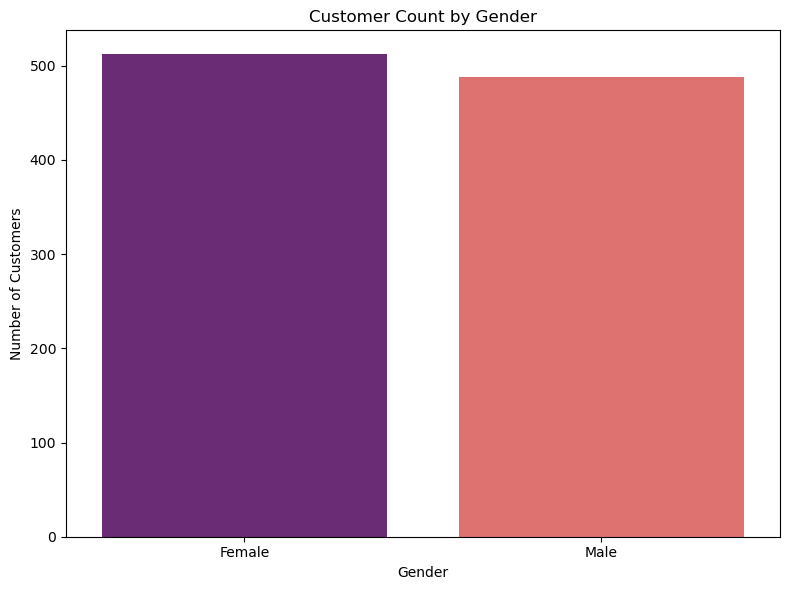

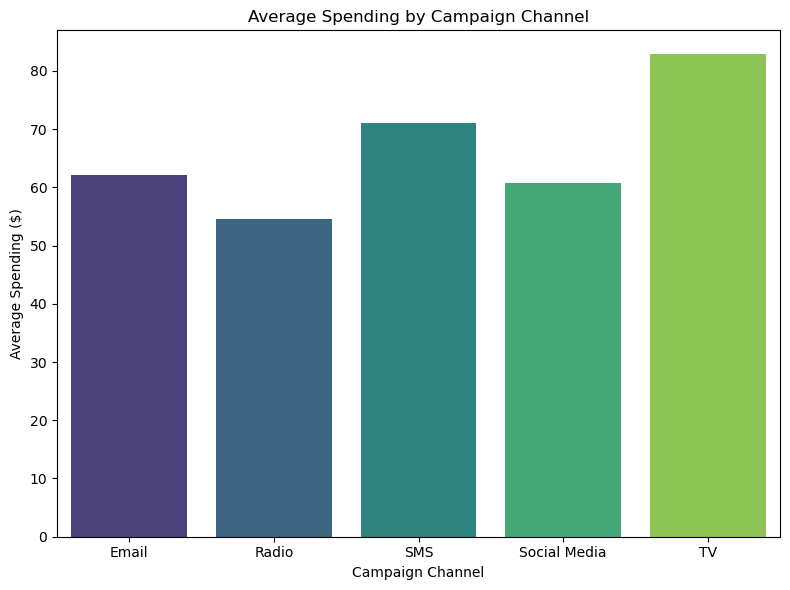

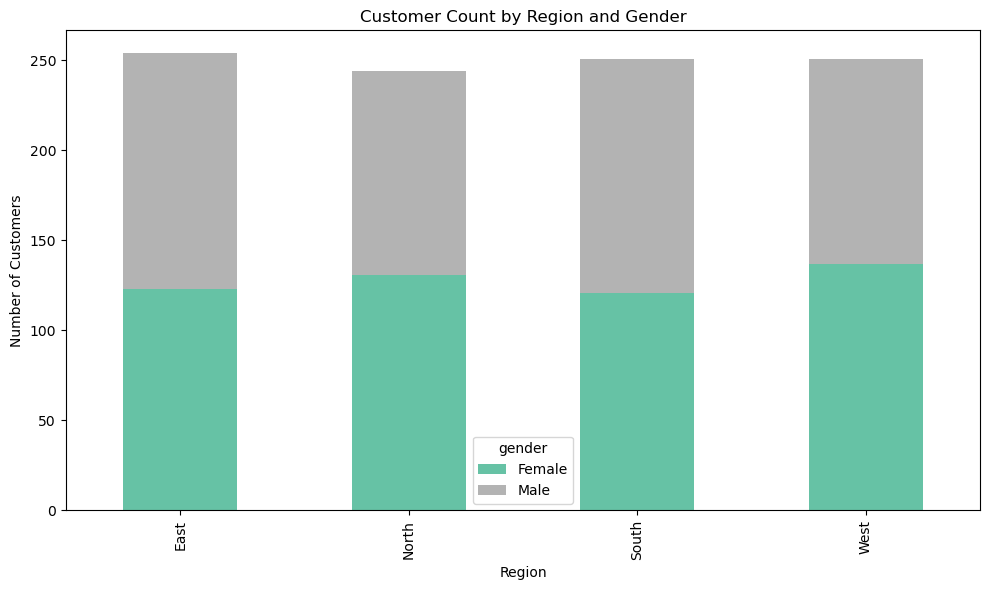

In [10]:
# Marketing Campaign Insights with SQL


import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
import random
import os

#Generate Synthetic Dataset
fake = Faker()
Faker.seed(42)
random.seed(42)

channels = ['Email', 'SMS', 'Social Media', 'TV', 'Radio']
regions = ['North', 'South', 'East', 'West']
genders = ['Male', 'Female']

n_rows = 1000
data = []

for _ in range(n_rows):
    customer_id = fake.uuid4()
    age = random.randint(18, 65)
    gender = random.choice(genders)
    region = random.choice(regions)
    channel = random.choice(channels)
    campaign_date = fake.date_between(start_date='-1y', end_date='today')
    response = random.choices(['Yes', 'No'], weights=[0.25, 0.75])[0]
    amount_spent = round(random.uniform(10, 500), 2) if response == 'Yes' else 0.0

    data.append([
        customer_id, age, gender, region, channel, campaign_date, response, amount_spent
    ])

columns = ["customer_id", "age", "gender", "region", "campaign_channel", "campaign_date", "response", "amount_spent"]
df = pd.DataFrame(data, columns=columns)

# Save to CSV and load back
os.makedirs("data", exist_ok=True)
data_path = "data/marketing_campaign.csv"
df.to_csv(data_path, index=False)
df = pd.read_csv(data_path)

# SQLite Database and Load Data
conn = sqlite3.connect("marketing_campaign.db")
df.to_sql("campaign_data", conn, if_exists="replace", index=False)

#  Queries
# Response Rate by Campaign Channel
query1 = """
SELECT campaign_channel, COUNT(*) AS total_sent,
       SUM(CASE WHEN response = 'Yes' THEN 1 ELSE 0 END) AS total_responded,
       ROUND(100.0 * SUM(CASE WHEN response = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS response_rate
FROM campaign_data
GROUP BY campaign_channel
ORDER BY response_rate DESC;
"""
# Revenue Share by Region
query2 = """
SELECT region, SUM(amount_spent) AS total_revenue
FROM campaign_data
WHERE response = 'Yes'
GROUP BY region
ORDER BY total_revenue DESC;
"""
# Monthly Responses Trend 
query3 = """
SELECT strftime('%Y-%m', campaign_date) AS month, COUNT(*) AS sent,
       SUM(CASE WHEN response = 'Yes' THEN 1 ELSE 0 END) AS responded
FROM campaign_data
GROUP BY month
ORDER BY month;
"""
#  Customer Demographics by Gender 
query4 = """
SELECT gender, COUNT(*) AS customer_count
FROM campaign_data
GROUP BY gender
"""

# Average Spending by Campaign Channel

query5 = """
SELECT campaign_channel, AVG(amount_spent) AS avg_spent
FROM campaign_data
GROUP BY campaign_channel
"""

# Customer Count by Region and Gender
query6 = """
SELECT region, gender, COUNT(*) AS customer_count
FROM campaign_data
GROUP BY region, gender
"""
#  Execute and Display Results
print("Response Rate by Campaign Channel:")
channel_data = pd.read_sql(query1, conn)
print(channel_data)

print("\nTotal Revenue by Region:")
region_data = pd.read_sql(query2, conn)
print(region_data)

print("\nMonthly Campaign Response Trend:")
trend_data = pd.read_sql(query3, conn)
print(trend_data)

print("\nCustomer Demographics by Gender:")
gender_data = pd.read_sql(query4, conn)
print(gender_data)

print("\nAverage Spending by Campaign Channel:")
avg_spending_data = pd.read_sql(query5, conn)
print(avg_spending_data)

print("\nCustomer Count by Region and Gender:")
region_gender_data = pd.read_sql(query6, conn)
print(region_gender_data)


# Visualization
os.makedirs("images", exist_ok=True)

# Visualization 1: Response Rate by Campaign Channel (Bar Chart)
plt.figure(figsize=(8, 5))
sns.barplot(data=channel_data, x='campaign_channel', y='response_rate', palette='viridis')
plt.title('Response Rate by Campaign Channel')
plt.ylabel('Response Rate (%)')
plt.xlabel('Campaign Channel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/response_by_channel.png")
plt.show()

# Visualization 2: Revenue Share by Region (Pie Chart)
plt.figure(figsize=(8, 6))
plt.pie(region_data['total_revenue'], labels=region_data['region'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('mako'))
plt.title('Revenue Share by Region')
plt.tight_layout()
plt.savefig("images/revenue_share_pie.png")
plt.show()

# Visualization 3: Monthly Responses Trend (Line Chart)
plt.figure(figsize=(10, 5))
plt.plot(trend_data['month'], trend_data['sent'], label='Sent', marker='o')
plt.plot(trend_data['month'], trend_data['responded'], label='Responded', marker='o')
plt.title('Monthly Campaign Engagement Trend')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("images/monthly_trend.png")
plt.show()

# Visualization 4: Customer Demographics by Gender (Bar Chart)
plt.figure(figsize=(8, 6))
sns.barplot(data=gender_data, x='gender', y='customer_count', palette='magma')
plt.title('Customer Count by Gender')
plt.ylabel('Number of Customers')
plt.xlabel('Gender')
plt.tight_layout()
plt.savefig("images/customer_demographics_by_gender.png")
plt.show()

# Visualization 5: Average Spending by Campaign Channel (Bar Chart)
plt.figure(figsize=(8, 6))
sns.barplot(data=avg_spending_data, x='campaign_channel', y='avg_spent', palette='viridis')
plt.title('Average Spending by Campaign Channel')
plt.ylabel('Average Spending ($)')
plt.xlabel('Campaign Channel')
plt.tight_layout()
plt.savefig("images/average_spending_by_channel.png")
plt.show()


# Visualization 6: Customer Count by Region and Gender (Stacked Bar Chart)

region_gender_pivot = region_gender_data.pivot(index='region', columns='gender', values='customer_count').fillna(0)

#  stacked bar chart
region_gender_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='Set2')
plt.title('Customer Count by Region and Gender')
plt.ylabel('Number of Customers')
plt.xlabel('Region')
plt.tight_layout()
plt.savefig("images/customer_count_by_region_and_gender.png")
plt.show()




